# Object detection

This notebook contains code for object detection for ROB535 Task 2.

## Imports and Data Prep

In [1]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

from engine import train_one_epoch, evaluate

In [2]:
DATA_PATH = '/home/saad/data/rob535/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_split = 0.8

# input_size = 224
input_size = 224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 25
BATCH_SIZE = 8

WEIGHT_DECAY = 0.01
LR = 0.003

HIDDEN_SIZE = 1024

In [4]:
def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:/
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e

def process_bbox(bbox, proj, img):
    R = rot(bbox[0, 0:3])
    t = bbox[0, 3:6]

    sz = bbox[0, 6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)
    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]
    lmin = max(np.min(vert_2D[0, :]), 0)
    lmax = min(np.max(vert_2D[0, :]), img.shape[2])
    umin = max(np.min(vert_2D[1, :]), 0)
    umax = min(np.max(vert_2D[1, :]), img.shape[1])
    
    return [[lmin, umin, lmax, umax]]

In [5]:
# Data loader
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_info, transform=None, target_transform=None):
        self.label_info = label_info
        self.shuffle_data()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def shuffle_data(self):
        self.label_info = self.label_info.sample(frac=1)
        self.img_labels = self.label_info["label"].values.tolist()
        self.img_files = self.label_info["guid/image"].values.tolist()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx]) + "_image.jpg"
        bbox_path = os.path.join(self.img_dir, self.img_files[idx]) + "_bbox.bin"
        proj_path = os.path.join(self.img_dir, self.img_files[idx]) + "_proj.bin"
        image = read_image(img_path).float() * 1.0/255
        obj_ids = np.array([1, 2])
        num_objs = 2
        
        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        bbox = np.fromfile(bbox_path, np.float32).reshape([-1, 11])
        proj = np.fromfile(proj_path, np.float32).reshape([3, 4])
        boxes = torch.as_tensor(process_bbox(bbox, proj, image), dtype=torch.float32)

    
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

In [6]:
# Shuffle, Split Data into train/val
label_info = pd.read_csv(os.path.join(DATA_PATH, "trainval", "labels.csv"))
label_info = label_info.sample(frac=1)

split_point = int(train_split * label_info["label"].size) 

img_dir = os.path.join(DATA_PATH, "trainval")


training_data = CustomImageDataset(img_dir, label_info[:split_point])
val_data = CustomImageDataset(img_dir, label_info[split_point:])

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

# Training

In [7]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    new_end = nn.Sequential(
        nn.Linear(in_features, HIDDEN_SIZE, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(HIDDEN_SIZE, in_features, bias=True),
        nn.ReLU(inplace=True),
        FastRCNNPredictor(in_features, num_classes)
    )
    model.roi_heads.box_predictor = new_end

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)
    
    optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)
    return model, optimizer
    
    

In [8]:
num_classes = 2

model, optimizer = create_model(num_classes)
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloaders['train'], device, epoch, print_freq=10)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    # evaluate on the test dataset
    evaluate(model, dataloaders['val'], device=device)


/home/saad/envs/sdc/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/467]  eta: 0:09:56  lr: 0.000009  loss: 0.7833 (0.7833)  loss_classifier: 0.6344 (0.6344)  loss_box_reg: 0.1298 (0.1298)  loss_objectness: 0.0146 (0.0146)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.2769  data: 0.1713  max mem: 8974
Epoch: [0]  [ 10/467]  eta: 0:09:25  lr: 0.000074  loss: 0.7803 (0.7808)  loss_classifier: 0.6309 (0.6283)  loss_box_reg: 0.1276 (0.1319)  loss_objectness: 0.0144 (0.0148)  loss_rpn_box_reg: 0.0049 (0.0057)  time: 1.2375  data: 0.1711  max mem: 9247
Epoch: [0]  [ 20/467]  eta: 0:09:11  lr: 0.000138  loss: 0.7688 (0.7641)  loss_classifier: 0.6165 (0.6086)  loss_box_reg: 0.1267 (0.1322)  loss_objectness: 0.0144 (0.0168)  loss_rpn_box_reg: 0.0049 (0.0065)  time: 1.2327  data: 0.1676  max mem: 9247
Epoch: [0]  [ 30/467]  eta: 0:09:01  lr: 0.000202  loss: 0.7019 (0.7291)  loss_classifier: 0.5418 (0.5726)  loss_box_reg: 0.1338 (0.1326)  loss_objectness: 0.0155 (0.0170)  loss_rpn_box_reg: 0.0073 (0.0068)  time: 1.2414  data: 0.1703  max mem: 9247


Epoch: [0]  [330/467]  eta: 0:02:53  lr: 0.002132  loss: 0.1489 (0.2952)  loss_classifier: 0.0252 (0.1373)  loss_box_reg: 0.1137 (0.1465)  loss_objectness: 0.0004 (0.0080)  loss_rpn_box_reg: 0.0020 (0.0033)  time: 1.2687  data: 0.1682  max mem: 9247
Epoch: [0]  [340/467]  eta: 0:02:40  lr: 0.002196  loss: 0.1347 (0.2902)  loss_classifier: 0.0252 (0.1341)  loss_box_reg: 0.0990 (0.1450)  loss_objectness: 0.0004 (0.0078)  loss_rpn_box_reg: 0.0019 (0.0033)  time: 1.2680  data: 0.1680  max mem: 9247
Epoch: [0]  [350/467]  eta: 0:02:27  lr: 0.002260  loss: 0.1253 (0.2853)  loss_classifier: 0.0282 (0.1311)  loss_box_reg: 0.0909 (0.1433)  loss_objectness: 0.0005 (0.0076)  loss_rpn_box_reg: 0.0020 (0.0033)  time: 1.2697  data: 0.1670  max mem: 9247
Epoch: [0]  [360/467]  eta: 0:02:15  lr: 0.002325  loss: 0.1111 (0.2805)  loss_classifier: 0.0269 (0.1283)  loss_box_reg: 0.0794 (0.1413)  loss_objectness: 0.0014 (0.0076)  loss_rpn_box_reg: 0.0026 (0.0033)  time: 1.2705  data: 0.1659  max mem: 9247


Epoch: [1]  [120/467]  eta: 0:07:14  lr: 0.003000  loss: 0.0867 (0.0829)  loss_classifier: 0.0238 (0.0251)  loss_box_reg: 0.0618 (0.0539)  loss_objectness: 0.0004 (0.0022)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 1.2533  data: 0.1519  max mem: 9247
Epoch: [1]  [130/467]  eta: 0:07:01  lr: 0.003000  loss: 0.0843 (0.0833)  loss_classifier: 0.0254 (0.0253)  loss_box_reg: 0.0574 (0.0540)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 1.2538  data: 0.1518  max mem: 9247
Epoch: [1]  [140/467]  eta: 0:06:49  lr: 0.003000  loss: 0.0747 (0.0826)  loss_classifier: 0.0233 (0.0251)  loss_box_reg: 0.0527 (0.0536)  loss_objectness: 0.0014 (0.0022)  loss_rpn_box_reg: 0.0012 (0.0016)  time: 1.2542  data: 0.1513  max mem: 9247
Epoch: [1]  [150/467]  eta: 0:06:37  lr: 0.003000  loss: 0.0747 (0.0821)  loss_classifier: 0.0216 (0.0250)  loss_box_reg: 0.0462 (0.0534)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 1.2560  data: 0.1528  max mem: 9247


Epoch: [1]  [450/467]  eta: 0:00:21  lr: 0.003000  loss: 0.0746 (0.0778)  loss_classifier: 0.0226 (0.0242)  loss_box_reg: 0.0457 (0.0498)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0013 (0.0016)  time: 1.2538  data: 0.1517  max mem: 9247
Epoch: [1]  [460/467]  eta: 0:00:08  lr: 0.003000  loss: 0.0746 (0.0777)  loss_classifier: 0.0215 (0.0242)  loss_box_reg: 0.0454 (0.0497)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 1.2561  data: 0.1515  max mem: 9247
Epoch: [1]  [466/467]  eta: 0:00:01  lr: 0.003000  loss: 0.0761 (0.0777)  loss_classifier: 0.0232 (0.0242)  loss_box_reg: 0.0448 (0.0497)  loss_objectness: 0.0010 (0.0023)  loss_rpn_box_reg: 0.0012 (0.0016)  time: 1.2189  data: 0.1473  max mem: 9247
Epoch: [1] Total time: 0:09:45 (1.2537 s / it)
creating index...
index created!
Test:  [  0/117]  eta: 0:01:25  model_time: 0.5077 (0.5077)  evaluator_time: 0.0041 (0.0041)  time: 0.7300  data: 0.1950  max mem: 9247
Test:  [100/117]  eta: 0:00:12  mo

Epoch: [2]  [240/467]  eta: 0:04:44  lr: 0.003000  loss: 0.0671 (0.0696)  loss_classifier: 0.0226 (0.0228)  loss_box_reg: 0.0408 (0.0440)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.2555  data: 0.1529  max mem: 9247
Epoch: [2]  [250/467]  eta: 0:04:32  lr: 0.003000  loss: 0.0705 (0.0698)  loss_classifier: 0.0226 (0.0229)  loss_box_reg: 0.0453 (0.0440)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.2567  data: 0.1542  max mem: 9247
Epoch: [2]  [260/467]  eta: 0:04:19  lr: 0.003000  loss: 0.0651 (0.0696)  loss_classifier: 0.0212 (0.0229)  loss_box_reg: 0.0412 (0.0438)  loss_objectness: 0.0017 (0.0016)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 1.2552  data: 0.1526  max mem: 9247
Epoch: [2]  [270/467]  eta: 0:04:06  lr: 0.003000  loss: 0.0575 (0.0693)  loss_classifier: 0.0195 (0.0228)  loss_box_reg: 0.0354 (0.0436)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 1.2524  data: 0.1503  max mem: 9247


Epoch: [3]  [ 30/467]  eta: 0:09:08  lr: 0.003000  loss: 0.0762 (0.0749)  loss_classifier: 0.0239 (0.0255)  loss_box_reg: 0.0449 (0.0455)  loss_objectness: 0.0016 (0.0024)  loss_rpn_box_reg: 0.0011 (0.0015)  time: 1.2512  data: 0.1510  max mem: 9247
Epoch: [3]  [ 40/467]  eta: 0:08:55  lr: 0.003000  loss: 0.0710 (0.0732)  loss_classifier: 0.0216 (0.0248)  loss_box_reg: 0.0445 (0.0446)  loss_objectness: 0.0015 (0.0022)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.2506  data: 0.1501  max mem: 9247
Epoch: [3]  [ 50/467]  eta: 0:08:42  lr: 0.003000  loss: 0.0710 (0.0742)  loss_classifier: 0.0208 (0.0254)  loss_box_reg: 0.0453 (0.0452)  loss_objectness: 0.0014 (0.0023)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 1.2510  data: 0.1506  max mem: 9247
Epoch: [3]  [ 60/467]  eta: 0:08:30  lr: 0.003000  loss: 0.0725 (0.0745)  loss_classifier: 0.0263 (0.0254)  loss_box_reg: 0.0462 (0.0454)  loss_objectness: 0.0014 (0.0022)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.2530  data: 0.1510  max mem: 9247


Epoch: [3]  [360/467]  eta: 0:02:14  lr: 0.003000  loss: 0.0732 (0.0742)  loss_classifier: 0.0236 (0.0251)  loss_box_reg: 0.0457 (0.0451)  loss_objectness: 0.0012 (0.0024)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.2751  data: 0.1730  max mem: 9247
Epoch: [3]  [370/467]  eta: 0:02:02  lr: 0.003000  loss: 0.0734 (0.0744)  loss_classifier: 0.0284 (0.0252)  loss_box_reg: 0.0444 (0.0451)  loss_objectness: 0.0016 (0.0025)  loss_rpn_box_reg: 0.0018 (0.0016)  time: 1.2758  data: 0.1737  max mem: 9247
Epoch: [3]  [380/467]  eta: 0:01:49  lr: 0.003000  loss: 0.0805 (0.0746)  loss_classifier: 0.0284 (0.0253)  loss_box_reg: 0.0453 (0.0451)  loss_objectness: 0.0018 (0.0025)  loss_rpn_box_reg: 0.0021 (0.0016)  time: 1.2661  data: 0.1623  max mem: 9247
Epoch: [3]  [390/467]  eta: 0:01:36  lr: 0.003000  loss: 0.0722 (0.0744)  loss_classifier: 0.0249 (0.0252)  loss_box_reg: 0.0433 (0.0451)  loss_objectness: 0.0011 (0.0025)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.2586  data: 0.1521  max mem: 9247


Epoch: [4]  [150/467]  eta: 0:06:37  lr: 0.003000  loss: 0.0791 (0.0760)  loss_classifier: 0.0268 (0.0260)  loss_box_reg: 0.0487 (0.0458)  loss_objectness: 0.0016 (0.0025)  loss_rpn_box_reg: 0.0015 (0.0017)  time: 1.2526  data: 0.1479  max mem: 9247
Epoch: [4]  [160/467]  eta: 0:06:25  lr: 0.003000  loss: 0.0829 (0.0765)  loss_classifier: 0.0291 (0.0262)  loss_box_reg: 0.0473 (0.0461)  loss_objectness: 0.0020 (0.0026)  loss_rpn_box_reg: 0.0018 (0.0017)  time: 1.2538  data: 0.1485  max mem: 9247
Epoch: [4]  [170/467]  eta: 0:06:12  lr: 0.003000  loss: 0.0749 (0.0763)  loss_classifier: 0.0250 (0.0261)  loss_box_reg: 0.0454 (0.0460)  loss_objectness: 0.0022 (0.0025)  loss_rpn_box_reg: 0.0016 (0.0017)  time: 1.2509  data: 0.1461  max mem: 9247
Epoch: [4]  [180/467]  eta: 0:05:59  lr: 0.003000  loss: 0.0724 (0.0764)  loss_classifier: 0.0237 (0.0259)  loss_box_reg: 0.0454 (0.0461)  loss_objectness: 0.0015 (0.0026)  loss_rpn_box_reg: 0.0014 (0.0017)  time: 1.2493  data: 0.1453  max mem: 9247


creating index...
index created!
Test:  [  0/117]  eta: 0:01:24  model_time: 0.5030 (0.5030)  evaluator_time: 0.0043 (0.0043)  time: 0.7262  data: 0.1958  max mem: 9247
Test:  [100/117]  eta: 0:00:12  model_time: 0.4861 (0.4867)  evaluator_time: 0.0043 (0.0044)  time: 0.7382  data: 0.2266  max mem: 9247
Test:  [116/117]  eta: 0:00:00  model_time: 0.4847 (0.4850)  evaluator_time: 0.0044 (0.0044)  time: 0.7252  data: 0.2238  max mem: 9247
Test: Total time: 0:01:25 (0.7342 s / it)
Averaged stats: model_time: 0.4847 (0.4850)  evaluator_time: 0.0044 (0.0044)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

In [10]:

import datetime
datetime_str = str(datetime.datetime.today().now())
if not os.path.exists('models'):
    os.makedirs('models')

torch.save(model, f'models/faster-rcnn-sim-{datetime_str}.pt')

# Testing

In [11]:
# model = torch.load('faster-rcnn-sim.pt')

In [12]:
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

torch.Size([3, 1052, 1914])
(2, 1)
(1, 1697) (1, 1697)


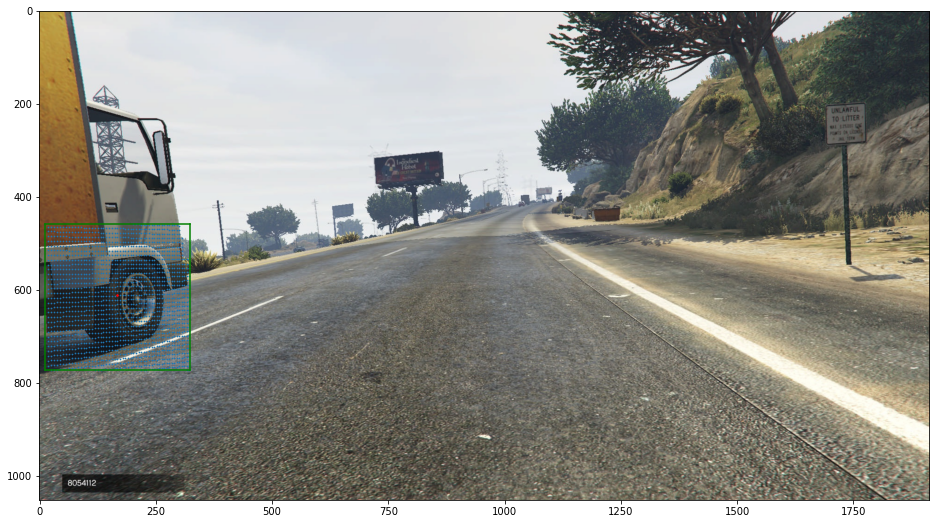

In [13]:
# load in testing data
test_imgs = glob(DATA_PATH + "test/*/*_image.jpg")
idx = np.random.randint(0, len(test_imgs))


cpu_device = torch.device("cpu")

image = read_image(test_imgs[idx])
print(image.shape)
gpu_image = image.float().unsqueeze(0).to(device) * 1.0 / 255
outputs = model(gpu_image)

fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)

outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

# for each image, load the point cloud, and take the closest point to the center of the bbox and assign it.
xyz = np.fromfile(test_imgs[idx].replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])
proj = np.fromfile(test_imgs[idx].replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]
dist = np.linalg.norm(xyz, axis=0)
# ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)

if len(outputs) > 0:
    if len(outputs[0]['boxes']) > 0:
        max_bbox = outputs[0]['boxes'][0].squeeze(0).detach().numpy()

        img_viz = image.numpy().transpose(1, 2, 0)
        top = [max_bbox[0], max_bbox[2], max_bbox[1], max_bbox[1]]
        left = [max_bbox[0], max_bbox[0], max_bbox[1], max_bbox[3]]
        right = [max_bbox[2], max_bbox[2], max_bbox[1], max_bbox[3]]
        bottom = [max_bbox[0], max_bbox[2], max_bbox[3], max_bbox[3]]

        ax1.plot(top[:2], top[-2:], color='green')
        ax1.plot(left[:2], left[-2:], color='green')
        ax1.plot(right[:2], right[-2:], color='green')
        ax1.plot(bottom[:2], bottom[-2:], color='green')
        
        # find points within bounding box
        xg = uv[0, uv[0, :] > max_bbox[0]]
        yg = uv[1, uv[0, :] > max_bbox[0]]
        xl = xg[xg < max_bbox[2]]
        yl = yg[xg < max_bbox[2]]
        xm = xl[yl > max_bbox[1]]
        ym = yl[yl > max_bbox[1]]
        xn = xm[ym < max_bbox[3]]
        yn = ym[ym < max_bbox[3]]
        ax1.scatter(xn, yn, marker='.', s=2)
        # y_vals = np.where(uv[1, :] > max_bbox[1] and uv[1, :] < max_bbox[3])

        # find closest point to center of bbox
        bbox_center = np.array([[max_bbox[0] + (max_bbox[2] - max_bbox[0]) / 2.0, max_bbox[1] + (max_bbox[3] - max_bbox[1]) / 2.0]]).T
        print(bbox_center.shape)
        
        # loop through points to find closest
        xn = np.array([xn])
        yn = np.array([yn])
        print(xn.shape, yn.shape)
        pts = np.vstack([xn, yn])

        reps = np.tile(bbox_center, [1, pts.shape[1]])
        diff = np.linalg.norm(reps - pts, axis=0)
        min_pt = pts[:, np.argmin(diff)] 
        
        # find where uv[0, :] = min_pr
        xlog = (uv[0, :] == min_pt[0])
        ylog = (uv[1, :] == min_pt[1])
        index = np.all([xlog, ylog], axis=0).nonzero()
    
        # Assign this value to be the centroid
        centroid = xyz[:, index]
        ax1.scatter(uv[0, index], uv[1, index], marker='.', s=10, c='red')
        
        # write to file
        
ax1.imshow(img_viz)



plt.show()

In [14]:
def test_outputs(model, filename, avg_centroid=[0,0,0]):
    # load in testing data
    test_imgs = glob(DATA_PATH + "test/*/*_image.jpg")
    if os.path.exists(filename):
        os.remove(filename)
    f = open(filename, 'w')
    f.write('guid/image/axis,value\n')
    for idx in range(0, len(test_imgs)):
        cpu_device = torch.device("cpu")

        image = read_image(test_imgs[idx])
        gpu_image = image.float().unsqueeze(0).to(device) * 1.0 / 255
        outputs = model(gpu_image)

        # for each image, load the point cloud, and take the closest point to the center of the bbox and assign it.
        xyz = np.fromfile(test_imgs[idx].replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
        xyz = xyz.reshape([3, -1])
        proj = np.fromfile(test_imgs[idx].replace('_image.jpg', '_proj.bin'), dtype=np.float32)
        proj.resize([3, 4])

        uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
        uv = uv / uv[2, :]
        centroid = avg_centroid
        if len(outputs) > 0:
            if len(outputs[0]['boxes']) > 0:
                max_bbox = outputs[0]['boxes'][0].squeeze(0).detach().cpu().numpy()

                img_viz = image.numpy().transpose(1, 2, 0)
                top = [max_bbox[0], max_bbox[2], max_bbox[1], max_bbox[1]]
                left = [max_bbox[0], max_bbox[0], max_bbox[1], max_bbox[3]]
                right = [max_bbox[2], max_bbox[2], max_bbox[1], max_bbox[3]]
                bottom = [max_bbox[0], max_bbox[2], max_bbox[3], max_bbox[3]]

                # find points within bounding box
                xg = uv[0, uv[0, :] > max_bbox[0]]
                yg = uv[1, uv[0, :] > max_bbox[0]]
                xl = xg[xg < max_bbox[2]]
                yl = yg[xg < max_bbox[2]]
                xm = xl[yl > max_bbox[1]]
                ym = yl[yl > max_bbox[1]]
                xn = xm[ym < max_bbox[3]]
                yn = ym[ym < max_bbox[3]]
                # ax1.scatter(xn, yn, marker='.', s=2)
                # y_vals = np.where(uv[1, :] > max_bbox[1] and uv[1, :] < max_bbox[3])

                # find closest point to center of bbox
                bbox_center = np.array([[max_bbox[0] + (max_bbox[2] - max_bbox[0]) / 2.0, max_bbox[1] + (max_bbox[3] - max_bbox[1]) / 2.0]]).T

                # loop through points to find closest
                xn = np.array([xn])
                yn = np.array([yn])
                pts = np.vstack([xn, yn])
                if pts.shape[1] > 0:
                    reps = np.tile(bbox_center, [1, pts.shape[1]])
                    diff = np.linalg.norm(reps - pts, axis=0)
                    min_pt = pts[:, np.argmin(diff)] 

                    # find where uv[0, :] = min_pr
                    xlog = (uv[0, :] == min_pt[0])
                    ylog = (uv[1, :] == min_pt[1])
                    index = np.all([xlog, ylog], axis=0).nonzero()

                    # Assign this value to be the centroid
                    centroid = xyz[:, index].squeeze()

        # get guid
        guid = test_imgs[idx].split('/')[-2]
        index_num = test_imgs[idx].split('/')[-1].split('_')[0]
        print(f"{guid}/{index_num}")
        f.write(f"{guid}/{index_num}/x,{centroid[0]}\n")
        f.write(f"{guid}/{index_num}/y,{centroid[1]}\n")
        f.write(f"{guid}/{index_num}/z,{centroid[2]}\n")        
    f.close()
    
            
    

In [15]:
test_outputs(model, 'task2_submission1.csv', avg_centroid=[-1.448003444373406, -1.7046494727975137, 24.54205491312801])

e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0003
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0102
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0068
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0061
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0097
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0094
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0063
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0039
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0028
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0013
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0050
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0059
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0090
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0082
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0027
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0037
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0055
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0008
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0100
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0001
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0052
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0087
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0080
e994ecfb-56d1-4704-ab7c-7d0e2ac7c2

0729ab2d-7fb0-4799-975f-c38fd350bf9c/0080
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0056
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0081
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0019
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0091
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0026
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0089
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0044
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0020
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0035
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0007
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0072
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0006
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0029
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0088
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0004
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0041
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0018
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0048
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0062
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0069
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0076
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0043
0729ab2d-7fb0-4799-975f-c38fd350bf

970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0049
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0012
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0114
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0154
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0095
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0109
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0085
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0146
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0127
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0178
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0040
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0021
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0157
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0086
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0051
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0054
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0176
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0129
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0108
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0053
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0075
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0160
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0070
970fdcc0-a7d2-494b-bbed-5660aaf1f7

0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0039
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0137
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0028
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0013
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0050
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0119
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0059
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0090
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0130
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0082
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0027
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0037
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0055
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0008
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0100
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0001
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0115
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0052
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0087
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0080
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0056
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0081
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0096
0ff0a23e-5f50-4461-8ccf-2b71bead2e

73dd2560-1057-4a74-ad6c-431079e2d054/0002
73dd2560-1057-4a74-ad6c-431079e2d054/0057
73dd2560-1057-4a74-ad6c-431079e2d054/0023
73dd2560-1057-4a74-ad6c-431079e2d054/0009
73dd2560-1057-4a74-ad6c-431079e2d054/0099
73dd2560-1057-4a74-ad6c-431079e2d054/0083
73dd2560-1057-4a74-ad6c-431079e2d054/0038
73dd2560-1057-4a74-ad6c-431079e2d054/0016
73dd2560-1057-4a74-ad6c-431079e2d054/0067
73dd2560-1057-4a74-ad6c-431079e2d054/0014
73dd2560-1057-4a74-ad6c-431079e2d054/0005
73dd2560-1057-4a74-ad6c-431079e2d054/0049
73dd2560-1057-4a74-ad6c-431079e2d054/0012
73dd2560-1057-4a74-ad6c-431079e2d054/0095
73dd2560-1057-4a74-ad6c-431079e2d054/0085
73dd2560-1057-4a74-ad6c-431079e2d054/0040
73dd2560-1057-4a74-ad6c-431079e2d054/0021
73dd2560-1057-4a74-ad6c-431079e2d054/0086
73dd2560-1057-4a74-ad6c-431079e2d054/0051
73dd2560-1057-4a74-ad6c-431079e2d054/0054
73dd2560-1057-4a74-ad6c-431079e2d054/0053
73dd2560-1057-4a74-ad6c-431079e2d054/0075
73dd2560-1057-4a74-ad6c-431079e2d054/0070
73dd2560-1057-4a74-ad6c-431079e2d0

0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0023
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0009
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0038
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0016
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0014
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0005
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0049
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0012
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0040
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0021
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0051
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0033
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0032
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0042
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0010
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0034
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0015
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0024
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0022
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0011
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0045
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0000
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0046
42f4f79e-caa5-4702-b54d-d48fa4e7ab

d78f61da-03c8-4f39-b843-f3f93be3da2f/0117
d78f61da-03c8-4f39-b843-f3f93be3da2f/0067
d78f61da-03c8-4f39-b843-f3f93be3da2f/0112
d78f61da-03c8-4f39-b843-f3f93be3da2f/0125
d78f61da-03c8-4f39-b843-f3f93be3da2f/0014
d78f61da-03c8-4f39-b843-f3f93be3da2f/0128
d78f61da-03c8-4f39-b843-f3f93be3da2f/0170
d78f61da-03c8-4f39-b843-f3f93be3da2f/0005
d78f61da-03c8-4f39-b843-f3f93be3da2f/0049
d78f61da-03c8-4f39-b843-f3f93be3da2f/0012
d78f61da-03c8-4f39-b843-f3f93be3da2f/0114
d78f61da-03c8-4f39-b843-f3f93be3da2f/0154
d78f61da-03c8-4f39-b843-f3f93be3da2f/0095
d78f61da-03c8-4f39-b843-f3f93be3da2f/0109
d78f61da-03c8-4f39-b843-f3f93be3da2f/0085
d78f61da-03c8-4f39-b843-f3f93be3da2f/0146
d78f61da-03c8-4f39-b843-f3f93be3da2f/0127
d78f61da-03c8-4f39-b843-f3f93be3da2f/0178
d78f61da-03c8-4f39-b843-f3f93be3da2f/0040
d78f61da-03c8-4f39-b843-f3f93be3da2f/0021
d78f61da-03c8-4f39-b843-f3f93be3da2f/0157
d78f61da-03c8-4f39-b843-f3f93be3da2f/0086
d78f61da-03c8-4f39-b843-f3f93be3da2f/0051
d78f61da-03c8-4f39-b843-f3f93be3da

cc9b0ffb-4041-4a90-82cf-992e88249b9b/0041
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0018
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0048
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0062
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0069
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0076
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0043
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0093
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0031
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0025
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0079
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0047
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0074
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0073
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0065
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0071
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0017
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0030
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0036
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0077
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0002
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0057
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0023
cc9b0ffb-4041-4a90-82cf-992e88249b

5375f8e6-96e9-4f49-97ff-d5df95f12464/0109
5375f8e6-96e9-4f49-97ff-d5df95f12464/0085
5375f8e6-96e9-4f49-97ff-d5df95f12464/0146
5375f8e6-96e9-4f49-97ff-d5df95f12464/0127
5375f8e6-96e9-4f49-97ff-d5df95f12464/0178
5375f8e6-96e9-4f49-97ff-d5df95f12464/0040
5375f8e6-96e9-4f49-97ff-d5df95f12464/0021
5375f8e6-96e9-4f49-97ff-d5df95f12464/0157
5375f8e6-96e9-4f49-97ff-d5df95f12464/0086
5375f8e6-96e9-4f49-97ff-d5df95f12464/0051
5375f8e6-96e9-4f49-97ff-d5df95f12464/0054
5375f8e6-96e9-4f49-97ff-d5df95f12464/0176
5375f8e6-96e9-4f49-97ff-d5df95f12464/0129
5375f8e6-96e9-4f49-97ff-d5df95f12464/0108
5375f8e6-96e9-4f49-97ff-d5df95f12464/0053
5375f8e6-96e9-4f49-97ff-d5df95f12464/0075
5375f8e6-96e9-4f49-97ff-d5df95f12464/0160
5375f8e6-96e9-4f49-97ff-d5df95f12464/0070
5375f8e6-96e9-4f49-97ff-d5df95f12464/0058
5375f8e6-96e9-4f49-97ff-d5df95f12464/0101
5375f8e6-96e9-4f49-97ff-d5df95f12464/0142
5375f8e6-96e9-4f49-97ff-d5df95f12464/0033
5375f8e6-96e9-4f49-97ff-d5df95f12464/0032
5375f8e6-96e9-4f49-97ff-d5df95f124

56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0010
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0143
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0105
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0034
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0015
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0064
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0106
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0147
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0138
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0098
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0152
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0066
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0024
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0156
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0122
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0145
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0132
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0134
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0022
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0118
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0139
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0084
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0011
56b6bc82-8545-4ac9-a5da-fc0c1f899b

748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0053
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0075
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0208
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0160
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0070
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0058
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0101
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0142
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0033
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0032
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0042
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0204
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0148
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0162
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0010
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0143
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0105
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0034
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0212
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0015
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0064
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0106
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0147
748e842e-ed85-45ca-b8f1-4acdcb76f3

b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0263
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0044
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0200
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0123
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0207
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0020
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0035
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0255
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0181
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0007
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0224
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0221
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0072
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0140
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0131
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0124
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0006
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0029
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0088
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0004
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0180
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0141
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0041
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9

301c7467-993f-4ce5-9952-1f9ab29e0992/0003
301c7467-993f-4ce5-9952-1f9ab29e0992/0039
301c7467-993f-4ce5-9952-1f9ab29e0992/0028
301c7467-993f-4ce5-9952-1f9ab29e0992/0013
301c7467-993f-4ce5-9952-1f9ab29e0992/0050
301c7467-993f-4ce5-9952-1f9ab29e0992/0027
301c7467-993f-4ce5-9952-1f9ab29e0992/0037
301c7467-993f-4ce5-9952-1f9ab29e0992/0008
301c7467-993f-4ce5-9952-1f9ab29e0992/0001
301c7467-993f-4ce5-9952-1f9ab29e0992/0019
301c7467-993f-4ce5-9952-1f9ab29e0992/0026
301c7467-993f-4ce5-9952-1f9ab29e0992/0044
301c7467-993f-4ce5-9952-1f9ab29e0992/0020
301c7467-993f-4ce5-9952-1f9ab29e0992/0035
301c7467-993f-4ce5-9952-1f9ab29e0992/0007
301c7467-993f-4ce5-9952-1f9ab29e0992/0006
301c7467-993f-4ce5-9952-1f9ab29e0992/0029
301c7467-993f-4ce5-9952-1f9ab29e0992/0004
301c7467-993f-4ce5-9952-1f9ab29e0992/0041
301c7467-993f-4ce5-9952-1f9ab29e0992/0018
301c7467-993f-4ce5-9952-1f9ab29e0992/0048
301c7467-993f-4ce5-9952-1f9ab29e0992/0043
301c7467-993f-4ce5-9952-1f9ab29e0992/0031
301c7467-993f-4ce5-9952-1f9ab29e09

effc00fc-f301-4971-bb8a-de2261a1db25/0047
effc00fc-f301-4971-bb8a-de2261a1db25/0074
effc00fc-f301-4971-bb8a-de2261a1db25/0073
effc00fc-f301-4971-bb8a-de2261a1db25/0065
effc00fc-f301-4971-bb8a-de2261a1db25/0071
effc00fc-f301-4971-bb8a-de2261a1db25/0017
effc00fc-f301-4971-bb8a-de2261a1db25/0030
effc00fc-f301-4971-bb8a-de2261a1db25/0036
effc00fc-f301-4971-bb8a-de2261a1db25/0077
effc00fc-f301-4971-bb8a-de2261a1db25/0002
effc00fc-f301-4971-bb8a-de2261a1db25/0057
effc00fc-f301-4971-bb8a-de2261a1db25/0107
effc00fc-f301-4971-bb8a-de2261a1db25/0023
effc00fc-f301-4971-bb8a-de2261a1db25/0104
effc00fc-f301-4971-bb8a-de2261a1db25/0136
effc00fc-f301-4971-bb8a-de2261a1db25/0009
effc00fc-f301-4971-bb8a-de2261a1db25/0099
effc00fc-f301-4971-bb8a-de2261a1db25/0083
effc00fc-f301-4971-bb8a-de2261a1db25/0038
effc00fc-f301-4971-bb8a-de2261a1db25/0016
effc00fc-f301-4971-bb8a-de2261a1db25/0117
effc00fc-f301-4971-bb8a-de2261a1db25/0067
effc00fc-f301-4971-bb8a-de2261a1db25/0112
effc00fc-f301-4971-bb8a-de2261a1db